In [174]:

import pandas as pd
import matplotlib.pyplot as plt
from os.path import exists
import ast
import pickle

The original essential genes dataset had 28166 rows but only 26791 had available sequences.

In [175]:
deg_dataset = pd.read_csv("datasets/essential_genes.csv", sep=';')
print(deg_dataset.shape)

eg_negative = pd.read_csv("datasets/essential_genes_negative.csv", sep=',')
print(eg_negative.shape)

(26791, 15)
(27684, 2)


Creating positive essential genes dataset. Each sequence needs to be in at least 5 datasets.

In [176]:
# for each sequence, get all the datasets that contain it
d = {}
for _, row in deg_dataset.iterrows():
    if(row["sequence"] in d):
        d[row["sequence"]].append((row["id1"], row["id4"]))
    else:
        d[row["sequence"]] = [(row["id1"], row["id4"])]


# get a list of sequences that are in more than 5 datasets
essential_sequences = []
for key, val in d.items():
    if(len(val) >= 5):
        essential_sequences.append((val[0][1], key))
        
# create dataframe with essential sequences
eg_positive = pd.DataFrame(essential_sequences, columns=["id", "sequence"])
print(eg_positive.head())
print(eg_positive.shape)

# write to csv
eg_positive.to_csv("datasets/essential_genes_positive.csv", index=False)

     id                                           sequence
0  GI:-  ATGGTGCTGTCCCAGAGACAACGAGATGAACTAAATCGAGCTATAG...
1  GI:-  ATGGCTGCAGCTTCATATGATCAGTTGTTAAAGCAAGTTGAGGCAC...
2  GI:-  ATGAGCCGCCTGCTCTGGAGGAAGGTGGCCGGCGCCACCGTCGGGC...
3  GI:-  ATGCAGAGCTGGAGTCGTGTGTACTGCTCCTTGGCCAAGAGAGGCC...
4  GI:-  ATGGTTGGCTATGACCCCAAACCAGATGGCAGGAATAACACCAAGT...
(2010, 2)


At this point, we have both positive and negative datasets:
* eg_positive -> positive dataset with essential genes (genes contained in at least 5 datasets) (2010, 2)
* eg_negative -> negative dataset with non essential genes (if sequences from the DEG dataset were on the Ensembl dataset, they were removed. Also, each sequence in DEG dataset had an EMBL id associated and, even if the sequence itself was not the same with the sequence with that ID in the EMBL dataset, they also go removed, forming the negative dataset) (27684, 2)

In [177]:
print("unique positive sequences:", len(set(eg_positive["sequence"])))
print("unique negative sequences:", len(set(eg_negative["sequence"])))

unique positive sequences: 2010
unique negative sequences: 23443


Even though the negative dataset has 27684 sequences, not all of them are unique. So, we need to remove the duplicates.

In [178]:
eg_negative = eg_negative.drop_duplicates(subset="sequence")
print(eg_negative.shape)

(23443, 2)


Calculating length of each sequence and cleaning up the data

In [179]:
eg_positive["length"] = eg_positive["sequence"].str.len()
eg_negative["length"] = eg_negative["sequence"].str.len()

In [180]:
print("before removing")
print(eg_positive.shape)
print(eg_negative.shape)

old_eg_positive = eg_positive.shape[0]
old_eg_negative = eg_negative.shape[0]

eg_positive = eg_positive[eg_positive["length"] <= 20000]
eg_negative = eg_negative[eg_negative["length"] <= 20000]
print("after removing")
print(eg_positive.shape, old_eg_positive - eg_positive.shape[0], "were removed")
print(eg_negative.shape, old_eg_negative - eg_negative.shape[0], "were removed")

before removing
(2010, 3)
(23443, 3)
after removing
(2010, 3) 0 were removed
(23439, 3) 4 were removed


Statistics about the data, including:
* Total sequences
* Top 5 longest and shortest sequences
* Average length of sequences
* Top 5 most and least common sequence length

In [181]:
def stats(dataset):
    dataset["length"].hist(bins=100)
    plt.show()

    print("-" * 40)

    print("Total sequences:", dataset.shape[0])

    print("-" * 40)

    print("Top 5 longest sequences:")
    print("id       length")
    print(dataset["length"].nlargest(5).to_string())

    print("-" * 40)

    print("Top 5 shortest sequences:")
    print("id       length")
    print(dataset["length"].nsmallest(5).to_string())

    print("-" * 40)

    average_length = dataset["length"].mean()
    print("Average length:", average_length)

    print("-" * 40)

    print("Top 5 most common lengths:")
    print("length   count")
    print(dataset["length"].value_counts().nlargest(5).to_string())
    
    print("-" * 40)

    print("Top 5 least common lengths:")
    print("length   count")
    print(dataset["length"].value_counts().nsmallest(5).to_string())

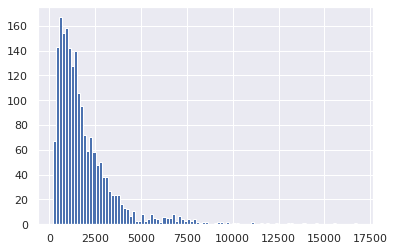

----------------------------------------
Total sequences: 2010
----------------------------------------
Top 5 longest sequences:
id       length
676    16791
248    15615
204    14574
491    13941
31     13167
----------------------------------------
Top 5 shortest sequences:
id       length
1112    192
1427    195
1500    204
1611    204
1346    210
----------------------------------------
Average length: 1903.6034825870647
----------------------------------------
Top 5 most common lengths:
length   count
1083    9
1041    8
618     7
585     7
1314    7
----------------------------------------
Top 5 least common lengths:
length   count
4311    1
2289    1
2958    1
513     1
2799    1
****************************************************************************************************


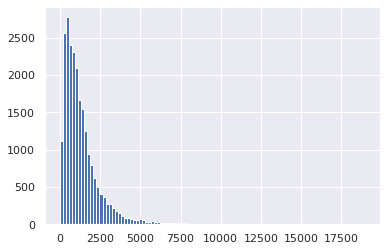

----------------------------------------
Total sequences: 23439
----------------------------------------
Top 5 longest sequences:
id       length
20105    18921
2852     17673
12774    17388
23013    17289
25523    16965
----------------------------------------
Top 5 shortest sequences:
id       length
6728      3
14762     5
13586    10
23228    10
25635    12
----------------------------------------
Average length: 1351.6297196979394
----------------------------------------
Top 5 most common lengths:
length   count
939    98
945    76
930    72
444    66
948    63
----------------------------------------
Top 5 least common lengths:
length   count
644      1
997      1
11724    1
607      1
10896    1


In [182]:
stats(eg_positive)
print("*" * 100)
stats(eg_negative)

Joining the positive and negative datasets

In [183]:
# adding labels to the dataset
eg_positive["label"] = 1
eg_negative["label"] = 0

# removing length column
eg_positive = eg_positive.drop(columns=["length"])
eg_negative = eg_negative.drop(columns=["length"])

# joining the two datasets
dataset = pd.concat([eg_positive, eg_negative])
print(dataset.shape)
print(dataset.head())

(25449, 3)
     id                                           sequence  label
0  GI:-  ATGGTGCTGTCCCAGAGACAACGAGATGAACTAAATCGAGCTATAG...      1
1  GI:-  ATGGCTGCAGCTTCATATGATCAGTTGTTAAAGCAAGTTGAGGCAC...      1
2  GI:-  ATGAGCCGCCTGCTCTGGAGGAAGGTGGCCGGCGCCACCGTCGGGC...      1
3  GI:-  ATGCAGAGCTGGAGTCGTGTGTACTGCTCCTTGGCCAAGAGAGGCC...      1
4  GI:-  ATGGTTGGCTATGACCCCAAACCAGATGGCAGGAATAACACCAAGT...      1


## Classification using DNA descriptors

In [184]:
import sys
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, matthews_corrcoef
from sklearn.preprocessing import StandardScaler

sys.path.append('../../../../src/')
from propythia.shallow_ml import ShallowML
from propythia.DNA.descriptors.descriptors import DNADescriptor

In [185]:
print(dataset.shape)

(25449, 3)


<AxesSubplot:xlabel='label'>

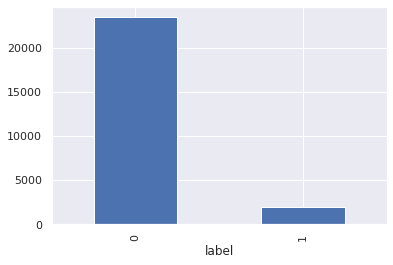

In [186]:
# plot the distribution of each class
dataset.groupby('label').size().plot(kind='bar')

In [188]:
# List of descriptors to be calculed. If empty, all descriptors will be calculated.
specifics = []

def calculate_feature(data):
    list_feature = []
    count = 0
    not_valid = 0
    for seq in data['sequence']:
        res = {'sequence': seq}
        dna = DNADescriptor(seq)
        try:
            feature = dna.get_descriptors(specifics=specifics)
            res.update(feature)
            list_feature.append(res)
        except ZeroDivisionError:
            not_valid += 1
        # print progress every 100 sequences
        if count % 100 == 0:
            print(count, '/', len(data))

        count += 1
    print("Done!")
    df = pd.DataFrame(list_feature)
    return df, not_valid


# ----------------------------------- Using pickle -----------------------------------
# if the file exists, load the data from the file
if exists("datasets/essential_genes_features.pkl"):
    with open("datasets/essential_genes_features.pkl", "rb") as f:
        features = pickle.load(f)
else:
    features, not_valid = calculate_feature(dataset)
    print("Not valid:", not_valid)
    with open("datasets/essential_genes_features.pkl", "wb") as f:
        pickle.dump(features, f)

# ----------------------------------- Using csv -----------------------------------
# file_exists = exists('datasets/essential_genes_features.csv')
# if(file_exists):
#     features = pd.read_csv('datasets/essential_genes_features.csv')
#     # converting each column to its corresponding type
#     count = 0
#     for i in features.columns[4:]:
#         features[i] = features[i].apply(lambda x: ast.literal_eval(x)) 
#         print(count, '/', len(features.columns[4:]))
#         count += 1
# else:
#     features, not_valid = calculate_feature(dataset)
#     print("Not valid:", not_valid)
#     features.to_csv("datasets/essential_genes_features.csv", index=False, sep=';')

SyntaxError: unexpected EOF while parsing (3302909747.py, line 47)

In [ ]:
fps_y = dataset['label']
fps_x = features.loc[:, features.columns != 'label']
fps_x = fps_x.loc[:, fps_x.columns != 'sequence']
fps_x.shape

(10, 20)

In [ ]:
no_need_normalization = ["length", "at_content", "gc_content"]

need_dict_normalization = ["nucleic_acid_composition", "enhanced_nucleic_acid_composition","dinucleotide_composition","trinucleotide_composition","k_spaced_nucleic_acid_pairs","kmer","PseDNC", "PseKNC"]

need_list_normalization = ["nucleotide_chemical_property", "accumulated_nucleotide_frequency", "DAC", "DCC", "DACC", "TAC","TCC","TACC", "binary"]

def normalize_dict(d, field):
    df = pd.json_normalize(d)
    df.columns = [str(field) + "_" + str(i) for i in df.columns]
    count = 0
    original_length = len(df.columns)
    for f in df.columns:
        if any(isinstance(elem, dict) for elem in df[f]):
            df = pd.concat([df, normalize_dict(df[f], f)], axis=1)
            df.drop(f, axis=1, inplace=True)
        if(count % 1000 == 0 and field == "enhanced_nucleic_acid_composition"):
            print(count, '/', original_length)
        count += 1
    return df

def normalize_list(l, field):
    df = pd.DataFrame([[] if i is None else i for i in l.to_list()])    
    df.columns = [str(field) + "_" + str(i) for i in df.columns]
    
    for f in df.columns:
        if isinstance(df[f][0], list):
            df = pd.concat([df, normalize_list(df[f], f)], axis=1)
            df.drop(f, axis=1, inplace=True)
    return df

new_fps_x = pd.DataFrame()
count = 0
for col in fps_x.columns:
    count += 1
    print("Calculating:", col, ":", count, '/', len(fps_x.columns))
    if col in need_dict_normalization:
        new_fps_x = pd.concat([new_fps_x, normalize_dict(fps_x[col], col)], axis=1)
    elif col in need_list_normalization:
        new_fps_x = pd.concat([new_fps_x, normalize_list(fps_x[col], col)], axis=1)
    else:
        new_fps_x[col] = fps_x[col].to_numpy()
    
    
print("writing to csv...")
new_fps_x.to_csv("fps_x.csv", index=False)
fps_y.to_csv("fps_y.csv", index=False)
new_fps_x

Calculating: length : 1 / 20
Calculating: gc_content : 2 / 20
Calculating: at_content : 3 / 20
Calculating: nucleic_acid_composition : 4 / 20
Calculating: enhanced_nucleic_acid_composition : 5 / 20
0 / 8528
1000 / 8528
2000 / 8528
3000 / 8528
4000 / 8528
5000 / 8528
6000 / 8528
7000 / 8528
8000 / 8528
Calculating: dinucleotide_composition : 6 / 20
Calculating: trinucleotide_composition : 7 / 20
Calculating: k_spaced_nucleic_acid_pairs : 8 / 20
Calculating: kmer : 9 / 20
Calculating: nucleotide_chemical_property : 10 / 20
Calculating: accumulated_nucleotide_frequency : 11 / 20
Calculating: DAC : 12 / 20
Calculating: DCC : 13 / 20
Calculating: DACC : 14 / 20
Calculating: TAC : 15 / 20
Calculating: TCC : 16 / 20
Calculating: TACC : 17 / 20
Calculating: PseDNC : 18 / 20
Calculating: PseKNC : 19 / 20
Calculating: binary : 20 / 20
writing to csv...


,length,gc_content,at_content,nucleic_acid_composition_A,nucleic_acid_composition_C,nucleic_acid_composition_G,nucleic_acid_composition_T,enhanced_nucleic_acid_composition_0_A,enhanced_nucleic_acid_composition_0_C,enhanced_nucleic_acid_composition_0_G,...,binary_1230_2,binary_1230_3,binary_1231_0,binary_1231_1,binary_1231_2,binary_1231_3,binary_1232_0,binary_1232_1,binary_1232_2,binary_1232_3
0,1233,0.440,0.560,0.303,0.193,0.247,0.256,0.2,0.0,0.4,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,8532,0.412,0.588,0.344,0.208,0.205,0.244,0.2,0.2,0.4,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,3720,0.604,0.396,0.215,0.290,0.314,0.181,0.4,0.0,0.4,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,1530,0.414,0.586,0.303,0.169,0.246,0.282,0.4,0.2,0.2,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,963,0.559,0.441,0.212,0.286,0.273,0.229,0.2,0.0,0.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1530,0.678,0.322,0.216,0.391,0.287,0.106,0.6,0.0,0.2,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,1533,0.460,0.540,0.290,0.211,0.249,0.250,0.4,0.0,0.2,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
7,438,0.580,0.420,0.258,0.272,0.308,0.162,0.2,0.4,0.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1914,0.449,0.551,0.303,0.206,0.243,0.248,0.2,0.0,0.6,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
9,1044,0.534,0.466,0.283,0.260,0.274,0.184,0.4,0.0,0.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Classification using Deep Learning and One hot encoding

In [ ]:
# average_length = int(average_length)

# cut sequences to the average length
# seqs_dataset = seqs_dataset.str.slice(0, average_length)

# fill with "N" the sequences that are shorter than average length
# seqs_dataset = seqs_dataset.str.pad(average_length, side='right', fillchar='N')